[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/justinhou95/DeepHedging/blob/main/deep%20efficient%20hedging.ipynb)

In [1]:
import sys
import os 
if '/content' in sys.path:
    if 'DeepHedging' in os.listdir():
        !rm -rf DeepHedging/
    !git clone https://github.com/justinhou95/DeepHedging/  
    import sys
    path = '/content/DeepHedging'
    if path not in sys.path:
        sys.path.append('/content/DeepHedging')

In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
keras = tf.keras
import utils.utils_efficient as utils_efficient
from importlib import reload 
print(tf.__version__)
reload(utils_efficient)

2.3.0


<module 'utils.utils_efficient' from 'C:\\SongyanHou\\Study\\Codes\\DeepHedging\\utils\\utils_efficient.py'>

In [2]:
reload(utils_efficient)
class EfficientHedgeCall:
    def __init__(self, po, trans_cost, L):
        self.trans_cost = trans_cost
        self.po = po
        self.N = N # time disrectization    
        self.S0 = S0 # initial value of the asset
        self.strike = strike
        self.K = strike
        self.L = L
        self.T = T
        self.dt = self.T / self.N
        self.initial_wealth = endow
        self.replicate_price = fp
        self.payoff_function = lambda x : 0.5*(np.abs(x-self.strike)+x-self.strike) # European call option payoff
        def ploss(payoff, outputs):
            if po == np.inf:
                self.strike_modified = self.L
#                 loss = tf.math.reduce_max(,keepdims = True)
                tmp = tf.sort(tf.nn.relu(payoff - outputs),axis = 0,direction='DESCENDING')
                loss = tf.reduce_mean(tmp[:100,:],keepdims = True)
                
                self.payoff_function_modified = lambda x : 0.5*(np.abs(x-self.strike_modified)+x-self.strike_modified) 
            elif po == 0:
                self.strike_modified = self.L
                loss = tf.math.sign(tf.nn.relu(payoff - outputs))
                self.payoff_function_modified = lambda x : (x-self.strike) * ((x < self.strike_modified) & (x > self.strike))
            elif po == 1:
                self.strike_modified = self.L
                loss = (tf.nn.relu(payoff - outputs))**po
                self.payoff_function_modified = lambda x : (x-self.strike) * (x > self.strike_modified) 
            else:
                if po < 1:
                    loss = (tf.nn.relu(payoff - outputs) + 1e-6)**po - 1e-6**po
                else:
                    loss = (tf.nn.relu(payoff - outputs))**po
                payoff_function_modified  = lambda x: (x-self.K - (self.L/x)**(alpha/(self.po-1))*(self.L-self.K)) * (x > self.L)
                self.payoff_function_modified = payoff_function_modified
            return loss
        x = ploss(tf.ones(shape = [1,1]), tf.ones(shape = [1,1]))
        self.ploss = ploss

    def generate_data(self):        
        self.m = 1 # dimension of price
        self.mu = mu
        self.sigma = sigma
        self.Ktrain = 10**5
        self.price_path, self.time_grid = utils_efficient.simulate_GBM(self.m,self.Ktrain,self.N,self.T,\
                                                             self.mu,self.sigma,self.S0, 'equi-exp')
        self.payoff = self.payoff_function(self.price_path[:,-1]) 
        self.payoff_modified = self.payoff_function_modified(self.price_path[:,-1])     

        self.delta_output, self.delta_path, self.option_path = utils_efficient.delta_hedge(self.price_path,\
            self.payoff_modified, self.T,self.strike, self.L,self.mu,self.sigma,self.po,self.time_grid)
        if self.trans_cost:
            self.delta_cost_output, self.hedge_cost_path, _ = utils_efficient.delta_hedge_cost(self.price_path,\
             self.payoff,self.T,self.strike, self.L,self.mu,self.sigma,self.po,self.time_grid)
                
    def plot_payoff(self):
        plt.figure(figsize = [8,3])
        plt.scatter(self.price_path[:,-1,0], self.delta_output[:,0], s = 1, alpha = 0.5, label = 'delta payoff')
        plt.scatter(self.price_path[:,-1,0], self.payoff[:,0], s = 1, alpha = 0.5, label = 'payoff')
        plt.scatter(self.price_path[:,-1,0], self.payoff_modified[:,0], s = 1, alpha = 0.5, label = 'modified payoff')
        plt.legend()
        plt.xlim(0,600)
        plt.ylim(-100,500)
        plt.grid()
        plt.show()
        
    def build_model(self):
        self.model_hedge, self.Network0, self.Networks = utils_efficient.build_dynamic_cost(self.m, self.N, self.trans_cost, self.initial_wealth, self.ploss, self.po)
    
    def prepare_data(self):    
        self.split = int(self.Ktrain/2)
        self.xtrain = [self.price_path[:self.split], self.payoff[:self.split]]  # input be price_path
        self.ytrain = self.payoff[:self.split]*0  # output be payoff
        self.xtest = [self.price_path[self.split:], self.payoff[:self.split]]  # input be price_path
        self.ytest = self.payoff[self.split:]*0  # output be payoff      
    def train(self, epochs):
        def zeroloss(y_true, y_predict):
            return tf.reduce_sum(y_predict*0)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # specify the optmizer 
        self.model_hedge.compile(optimizer = optimizer,loss=zeroloss) # specify the expected shortfall
        self.model_hedge.fit(x=self.xtrain,y=self.ytrain, epochs=epochs,verbose=True,batch_size=256) # train the model
    def predict(self):
        self.hedge_output_train = self.model_hedge.predict(self.xtrain) # compute the output (deep replicate payoff) with trained model 
        self.hedge_output_test = self.model_hedge.predict(self.xtest) # compute the output (deep replicate payoff) with trained model
        trainloss = tf.reduce_mean(self.ploss(self.payoff[:self.split], self.hedge_output_train)).numpy()
        testloss = tf.reduce_mean(self.ploss(self.payoff[self.split:], self.hedge_output_test)).numpy()
        print('ploss')
        if self.po not in [0,np.inf]:
            trainloss = trainloss**(1/self.po)
            testloss = testloss**(1/self.po)
        print('train: ',trainloss)
        print('test: ',testloss)
        print('delta: ',tf.reduce_mean(self.ploss(self.payoff, self.delta_output)).numpy()**(1/self.po))
        if self.trans_cost:
            pic = 4
            print('delta(cost): ',tf.reduce_mean(self.ploss(self.payoff, self.delta_cost_output)).numpy()**(1/self.po))
        else:
            pic = 3
        f,p = plt.subplots(1,pic, figsize = [20,5], sharey = True, sharex = True)
        p[0].scatter(self.price_path[self.split:,-1,0], self.hedge_output_test[:,0], s = 1, alpha = 0.5, label = 'deep hedge test ')
        p[1].scatter(self.price_path[:self.split,-1,0], self.hedge_output_train[:,0], s = 1, alpha = 0.5, label = 'deep hedge train') 
        p[2].scatter(self.price_path[:,-1,0], self.delta_output[:,0], s = 1, alpha = 0.5, label = 'delta_hedging')   
        if self.trans_cost:
            p[3].scatter(self.price_path[:,-1,0], self.delta_cost_output[:,0], s = 1, alpha = 0.5, label = 'delta_hedging (cost)')
            
        for i in range(pic):
            p[i].scatter(self.price_path[:,-1,0], self.payoff[:,0], s = 1, alpha = 0.5, label = 'real payoff')        # real payoff
            p[i].scatter(self.price_path[:,-1,0], self.payoff_modified[:,0], s = 1, alpha = 0.5, label = 'modified payoff') 
            p[i].legend()
            p[i].grid()
            if T > 1:
                plt.xlim(0,600)
                plt.ylim(-100,500)
        plt.show()
    def compare_strategy(self):
        f,p = plt.subplots(1,5,figsize = [20,5])
        for i in range(5):
            n = 20*i + 10
            pr = np.linspace(1,500,100)[:,None]  # tf.tensor of different price 

            he = self.Networks[n](tf.math.log(pr)) # the stategy network 
            p[i].plot(pr[:,0],he[:,0], label = 'deep hedge') # plot the relation between price and deep strategy
            if self.po == 0:
                BS_func = utils_efficient.BS0
            elif self.po == 1:
                BS_func = utils_efficient.BS1
            elif self.po == np.inf:
                BS_func = utils_efficient.BSinf   
            else:
                BS_func = utils_efficient.BSp
            _ , delta = BS_func(self.T - self.time_grid[n], pr, self.strike,self.L, self.mu,self.sigma, self.po)
            p[i].plot(pr, delta, label = 'delta hedge') # plot the relation between price and delta strategy
            p[i].title.set_text(f"At time: {self.time_grid[n]:{1}.{4}}")
            p[i].legend()
            p[i].grid()
        plt.show()

## Numerical results

In [3]:
S0 = 100.0 # initial value of the asset
strike = 110.
K = strike
mu = 0.08
sigma = 0.3
alpha = mu/sigma**2
N = 100
T = 10
fp,_ = utils_efficient.BSinf(T, S0, strike,strike, mu,sigma, p=0)
ratio = 0.7
endow = ratio * fp
print('replicate price: ',fp)
print('intial endowment: ',endow)
print('ratio: ',ratio)

replicate price:  33.476981678735086
intial endowment:  23.43388717511456
ratio:  0.7


In [4]:
def test(p,cost):
    L = utils_efficient.solver(T,S0,strike,mu,sigma,p,endow)
    model = EfficientHedgeCall(p, cost, L)
    model.generate_data()
    model.plot_payoff()
    model.build_model()
    model.prepare_data()
    model.train(30)
    model.predict()
    model.compare_strategy()
    return model

668
23.441348528142456


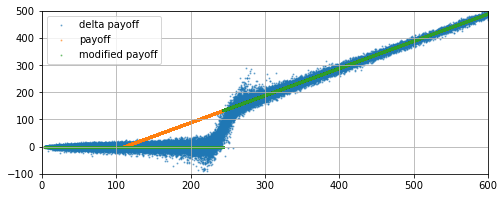

Epoch 1/30
196/196 [==============================] - 6s 30ms/step - loss: 286.7266 - p-loss: 57.4187 - 0-ad-loss: 228.4433: 2s - los
Epoch 2/30
196/196 [==============================] - 6s 30ms/step - loss: 49.4726 - p-loss: 39.6643 - 0-ad-loss: 9.8312
Epoch 3/30
196/196 [==============================] - 6s 30ms/step - loss: 45.5673 - p-loss: 36.3388 - 0-ad-loss: 9.2440
Epoch 4/30
196/196 [==============================] - 6s 30ms/step - loss: 44.2264 - p-loss: 35.9155 - 0-ad-loss: 8.3094
Epoch 5/30
196/196 [==============================] - 6s 30ms/step - loss: 42.3254 - p-loss: 33.9188 - 0-ad-loss: 8.4102
Epoch 6/30
196/196 [==============================] - 6s 30ms/step - loss: 41.7915 - p-loss: 33.6046 - 0-ad-loss: 8.1648 3s -
Epoch 7/30
196/196 [==============================] - 6s 30ms/step - loss: 42.4051 - p-loss: 34.0319 - 0-ad-loss: 8.3377
Epoch 8/30
196/196 [==============================] - 6s 30ms/step - loss: 40.8028 - p-loss: 32.8863 - 0-ad-loss: 7.9102
Epoch 9/30
196

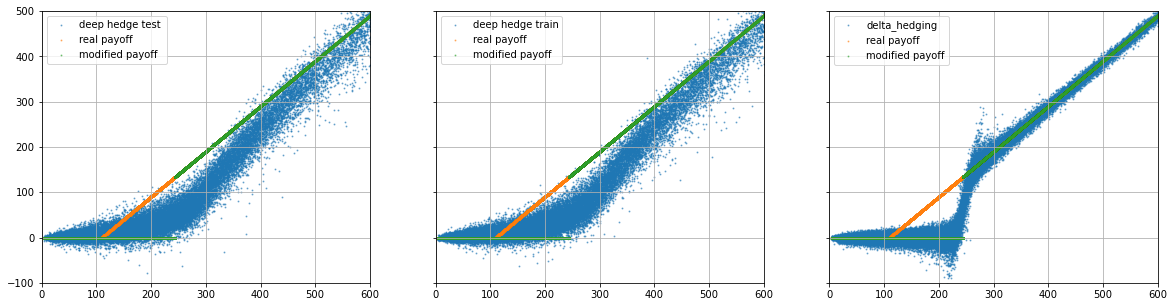

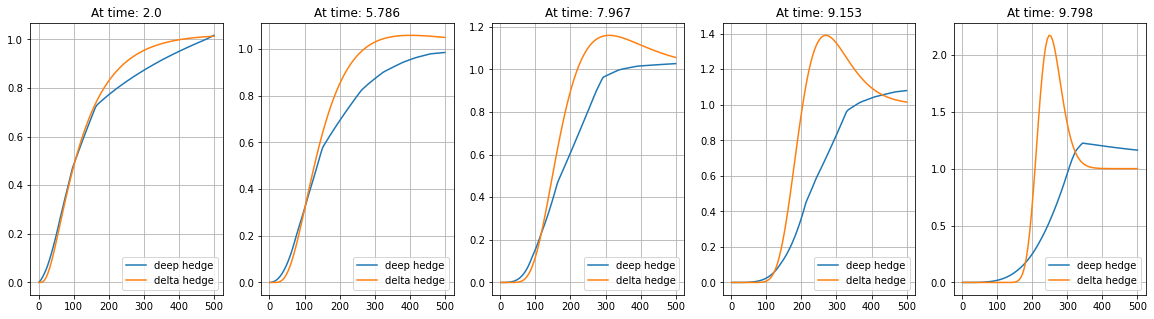

In [9]:
p = 1
cost = False
model_1 = test(p,cost)

668
23.42931381108701


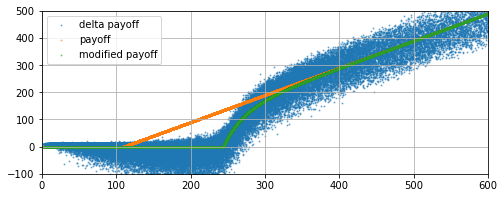

Epoch 1/30
196/196 [==============================] - 6s 32ms/step - loss: 256.0787 - p-loss: 83.4482 - 0-ad-loss: 172.1481: 4s - loss: 647.2474 - p-loss: 73.7927 - 0-ad-loss: 5 - ETA: 3s - loss: 541.4572 - p-loss: 80.5563 - 0-ad-loss: 460.90 - ETA
Epoch 2/30
196/196 [==============================] - 6s 33ms/step - loss: 63.5977 - p-loss: 50.6346 - 0-ad-loss: 12.9130: 4s - loss: 69.0171 - p-loss: 55. - ETA: 3s - loss:
Epoch 3/30
196/196 [==============================] - 6s 33ms/step - loss: 49.5645 - p-loss: 39.2285 - 0-ad-loss: 10.3157: 5s - loss: 50.2760 - p-loss: 39.6444 - 0 
Epoch 4/30
196/196 [==============================] - 6s 33ms/step - loss: 46.7466 - p-loss: 37.2438 - 0-ad-loss: 9.5009
Epoch 5/30
196/196 [==============================] - 6s 33ms/step - loss: 46.0162 - p-loss: 36.1873 - 0-ad-loss: 9.8046
Epoch 6/30
196/196 [==============================] - 6s 33ms/step - loss: 44.8904 - p-loss: 35.4870 - 0-ad-loss: 9.3755 3s - ETA: 1s - loss: 44.5758 - p-los - ETA: 0s - 

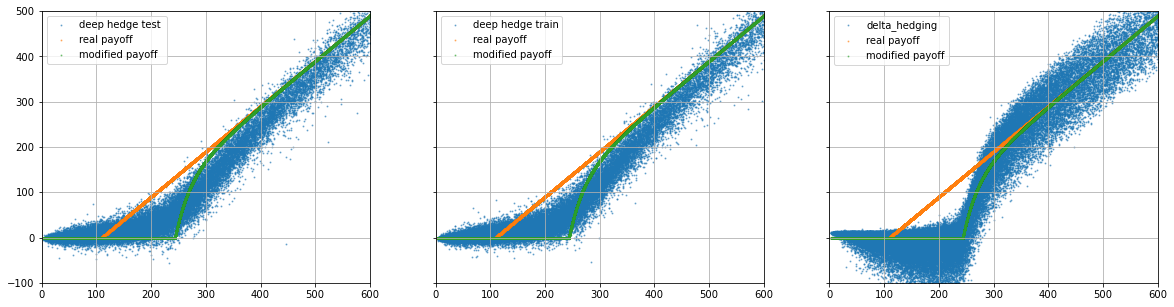

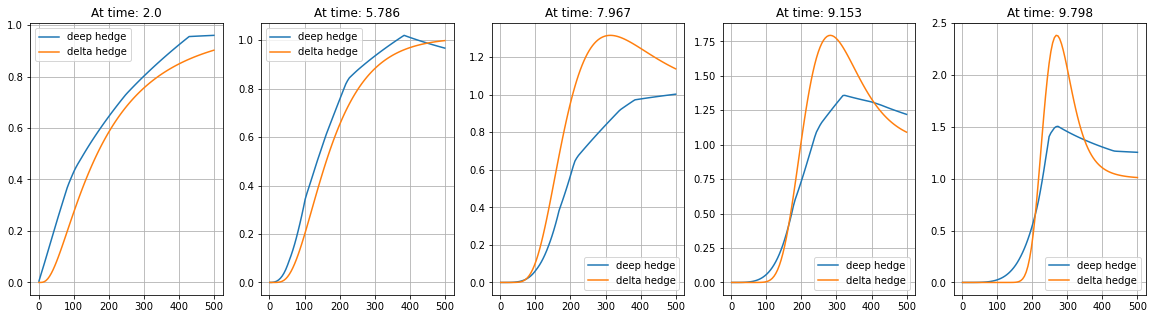

In [10]:
p = 1.1
cost = False
model_11 = test(p,cost)

253
23.44744224244743


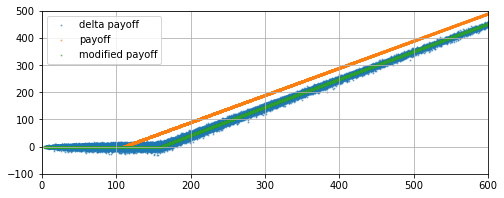

Epoch 1/30
196/196 [==============================] - 8s 41ms/step - loss: 518.5172 - p-loss: 188.3124 - 0-ad-loss: 328.8414
Epoch 2/30
196/196 [==============================] - 8s 42ms/step - loss: 166.9304 - p-loss: 123.5726 - 0-ad-loss: 43.3348
Epoch 3/30
196/196 [==============================] - 8s 42ms/step - loss: 129.1437 - p-loss: 97.7192 - 0-ad-loss: 31.3696
Epoch 4/30
196/196 [==============================] - 8s 42ms/step - loss: 128.8080 - p-loss: 95.5943 - 0-ad-loss: 33.2218
Epoch 5/30
196/196 [==============================] - 8s 42ms/step - loss: 104.2359 - p-loss: 79.1266 - 0-ad-loss: 25.0529
Epoch 6/30
196/196 [==============================] - 8s 42ms/step - loss: 87.4836 - p-loss: 65.7611 - 0-ad-loss: 21.6940
Epoch 7/30
196/196 [==============================] - 8s 42ms/step - loss: 105.3678 - p-loss: 78.4854 - 0-ad-loss: 26.7997
Epoch 8/30
196/196 [==============================] - 8s 43ms/step - loss: 91.2394 - p-loss: 67.8777 - 0-ad-loss: 23.4886: 0s - loss: 90.

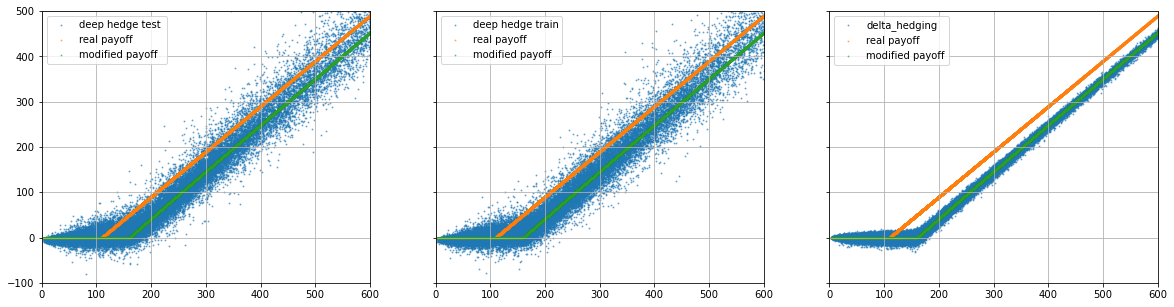

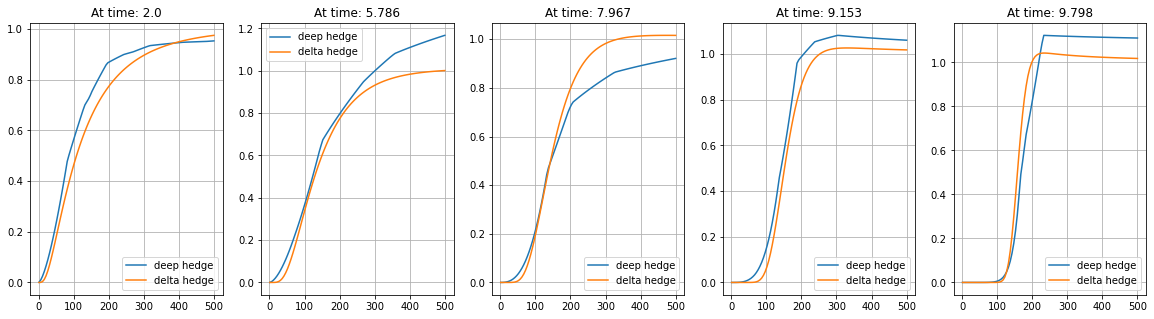

In [14]:
p = 5
cost = False
model_5 = test(p,cost)

225
23.429445281646046


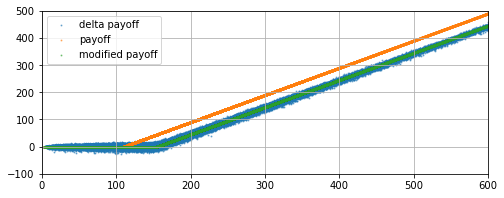

Epoch 1/30
196/196 [==============================] - 7s 38ms/step - loss: 315.9093 - p-loss: 118.5475 - 0-ad-loss: 196.4329
Epoch 2/30
196/196 [==============================] - 8s 40ms/step - loss: 87.6792 - p-loss: 59.9151 - 0-ad-loss: 27.6405
Epoch 3/30
196/196 [==============================] - 8s 40ms/step - loss: 79.6916 - p-loss: 53.8838 - 0-ad-loss: 25.6779
Epoch 4/30
196/196 [==============================] - 8s 40ms/step - loss: 76.8632 - p-loss: 50.7823 - 0-ad-loss: 26.0041
Epoch 5/30
196/196 [==============================] - ETA: 0s - loss: 74.8211 - p-loss: 49.6225 - 0-ad-loss: 25.198 - 8s 40ms/step - loss: 74.7877 - p-loss: 49.4787 - 0-ad-loss: 25.2359
Epoch 6/30
196/196 [==============================] - 8s 40ms/step - loss: 73.1992 - p-loss: 48.5620 - 0-ad-loss: 24.5854
Epoch 7/30
196/196 [==============================] - 8s 40ms/step - loss: 72.3555 - p-loss: 47.4074 - 0-ad-loss: 24.8603
Epoch 8/30
196/196 [==============================] - 8s 40ms/step - loss: 72.1

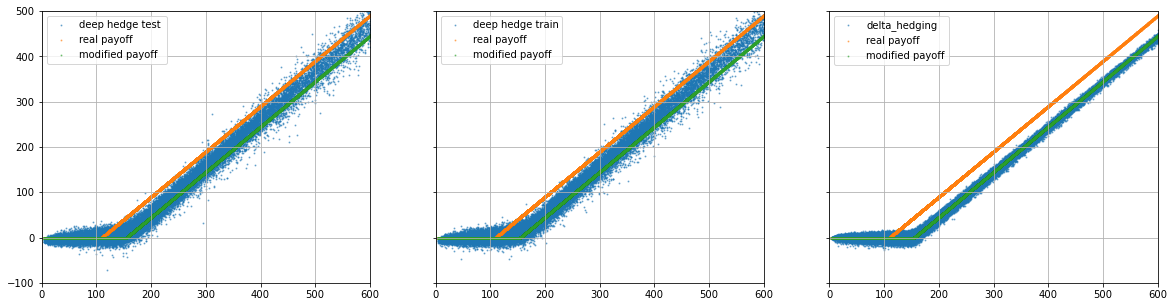

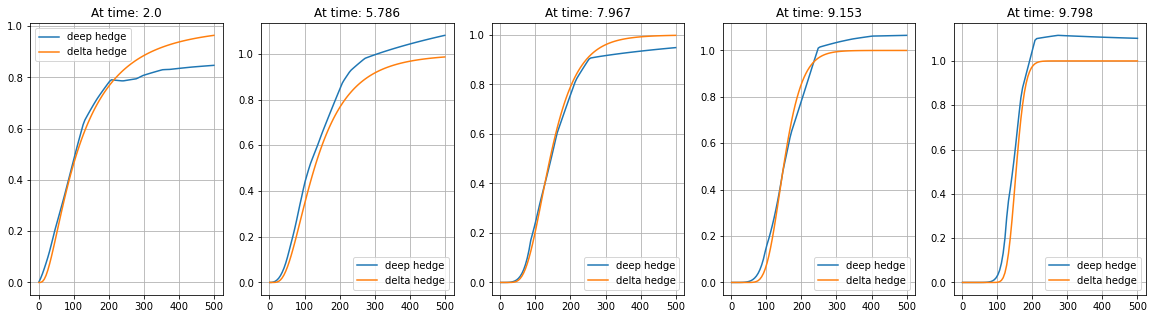

In [12]:
p = np.inf
cost = False
model_inf = test(p,cost)

## transaction cost

668
23.441348528142456


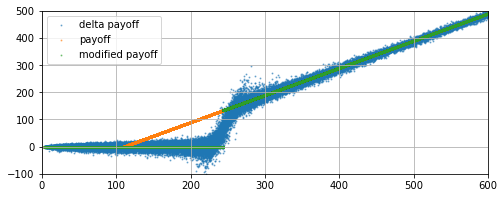

Epoch 1/30
196/196 [==============================] - 9s 44ms/step - loss: 374.4458 - p-loss: 76.4710 - 0-ad-loss: 296.9154 - tran_cost: 40.2435 1s - loss: 414.9700 - p-loss: 77.4844 - 0-ad-loss:
Epoch 2/30
196/196 [==============================] - 9s 45ms/step - loss: 65.0147 - p-loss: 55.8636 - 0-ad-loss: 9.1351 - tran_cost: 13.4665
Epoch 3/30
196/196 [==============================] - 9s 46ms/step - loss: 59.1113 - p-loss: 50.3745 - 0-ad-loss: 8.7388 - tran_cost: 14.0654: 4s - loss: 
Epoch 4/30
196/196 [==============================] - 9s 46ms/step - loss: 54.3082 - p-loss: 46.1679 - 0-ad-loss: 8.1386 - tran_cost: 12.3087: 6s - loss: 57.0315 - p-loss: 48.4872 - 0-ad-loss: 8.5443 - tran_ - E
Epoch 5/30
196/196 [==============================] - 9s 47ms/step - loss: 52.9399 - p-loss: 45.1536 - 0-ad-loss: 7.7917 - tran_cost: 11.6223
Epoch 6/30
196/196 [==============================] - 9s 46ms/step - loss: 52.1758 - p-loss: 44.2664 - 0-ad-loss: 7.9509 - tran_cost: 11.4149: 3s - loss:

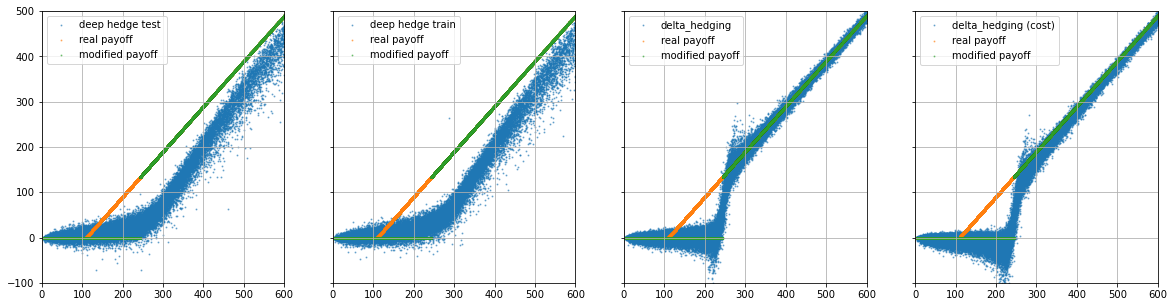

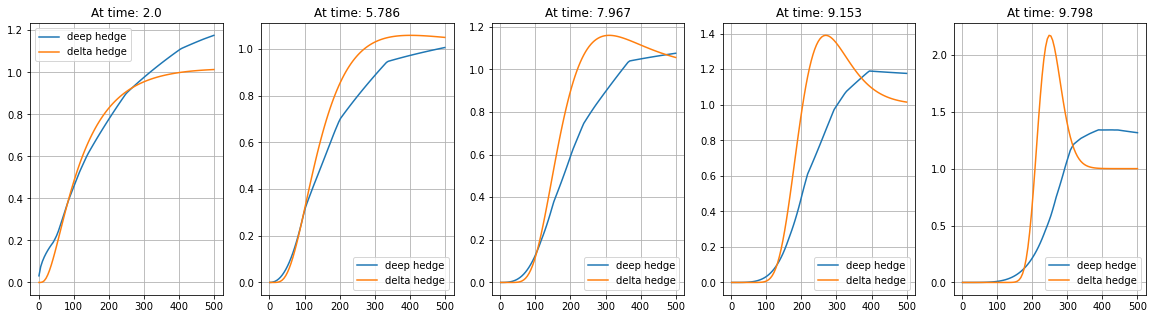

In [19]:
p = 1
cost = True
model_1_cost = test(p,cost)

668
23.42931381108701


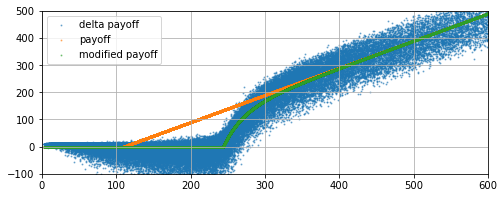

Epoch 1/30
196/196 [==============================] - 4s 18ms/step - loss: 380.5832 - p-loss: 81.8813 - 0-ad-loss: 297.6007 - tran_cost: 37.7603
Epoch 2/30
196/196 [==============================] - 4s 20ms/step - loss: 69.3407 - p-loss: 58.3354 - 0-ad-loss: 10.9845 - tran_cost: 15.6641
Epoch 3/30
196/196 [==============================] - 4s 20ms/step - loss: 59.7082 - p-loss: 50.1748 - 0-ad-loss: 9.5110 - tran_cost: 13.4204
Epoch 4/30
196/196 [==============================] - 3s 17ms/step - loss: 56.0940 - p-loss: 47.0200 - 0-ad-loss: 9.0598 - tran_cost: 11.9480
Epoch 5/30
196/196 [==============================] - 3s 17ms/step - loss: 55.1922 - p-loss: 46.1198 - 0-ad-loss: 9.0797 - tran_cost: 11.4894
Epoch 6/30
196/196 [==============================] - 3s 16ms/step - loss: 54.9899 - p-loss: 45.9446 - 0-ad-loss: 9.0646 - tran_cost: 11.4786
Epoch 7/30
196/196 [==============================] - 3s 17ms/step - loss: 54.1194 - p-loss: 45.0441 - 0-ad-loss: 9.0639 - tran_cost: 11.0427
Ep

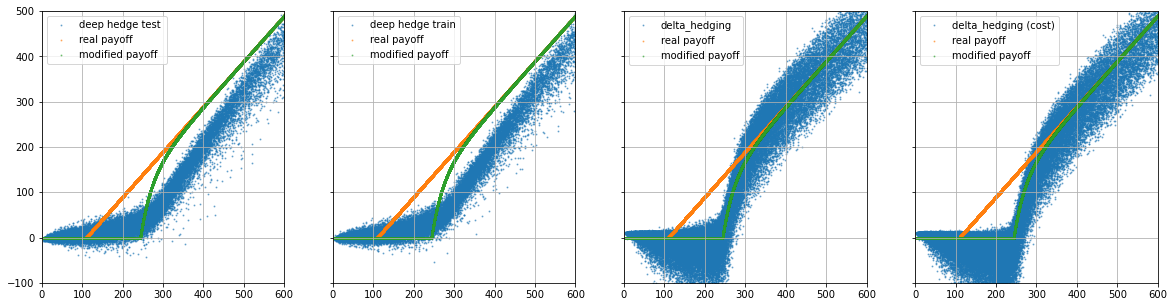

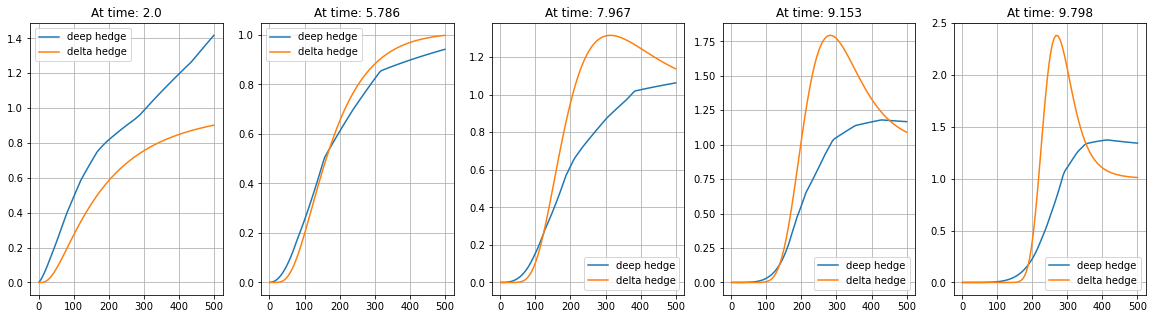

In [5]:
p = 1.1
cost = True
model_11_cost = test(p,cost)

253
23.44744224244743


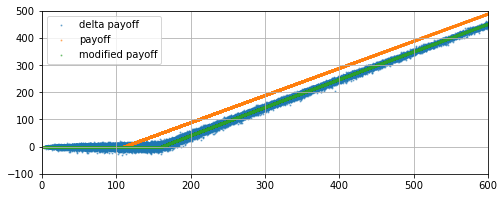

Epoch 1/30
196/196 [==============================] - 3s 15ms/step - loss: 634.4062 - p-loss: 192.4518 - 0-ad-loss: 440.6216 - tran_cost: 70.3688: 0s - loss: 652.2640 - p-loss: 193.2289 - 0-ad-loss: 459.0353 - tran_cost: 72.2
Epoch 2/30
196/196 [==============================] - 3s 16ms/step - loss: 176.7023 - p-loss: 130.5515 - 0-ad-loss: 45.9070 - tran_cost: 27.9418 1s - loss: 185.1099 - p-loss: 136.14
Epoch 3/30
196/196 [==============================] - 3s 16ms/step - loss: 132.3596 - p-loss: 99.6758 - 0-ad-loss: 32.5751 - tran_cost: 19.2890
Epoch 4/30
196/196 [==============================] - 3s 16ms/step - loss: 115.7908 - p-loss: 84.0818 - 0-ad-loss: 31.6992 - tran_cost: 16.52042s - loss: 90.686
Epoch 5/30
196/196 [==============================] - 3s 16ms/step - loss: 115.7064 - p-loss: 87.3755 - 0-ad-loss: 28.6900 - tran_cost: 16.9953
Epoch 6/30
196/196 [==============================] - 3s 16ms/step - loss: 140.2205 - p-loss: 103.3614 - 0-ad-loss: 36.7756 - tran_cost: 20.312

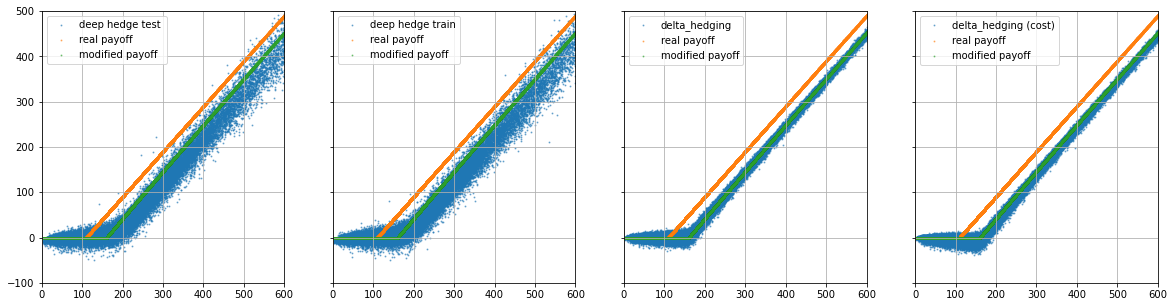

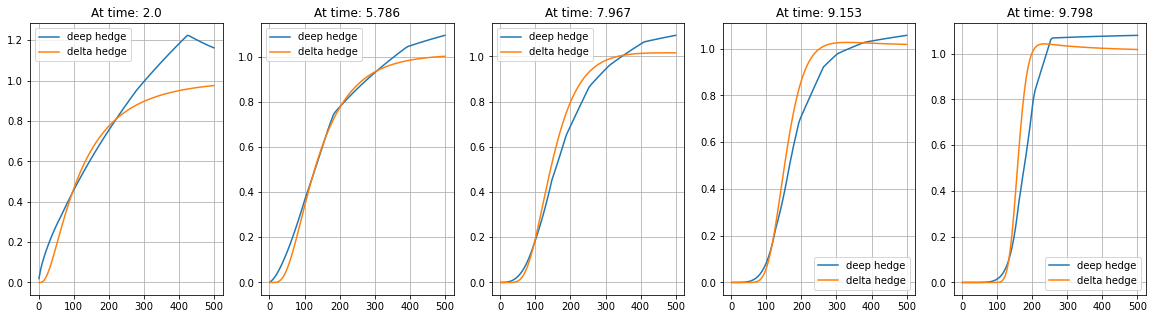

In [6]:
p = 5
cost = True
model_5_cost = test(p,cost)